<a href="https://colab.research.google.com/github/DEBG14/Graph-Machine-Learning/blob/main/GNNs_For_Citation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 13.9 MB/s eta 0:00:00


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

Processing...
Done!


In [ ]:
len(graph.x)

2708

In [ ]:
graph.edge_index.T


tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

<ipython-input-6-0cf531e943c3>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


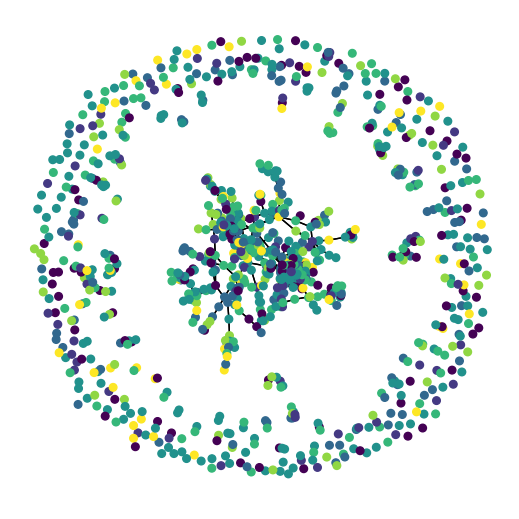

In [ ]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(5, 5))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()


g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [ ]:

import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

## Multilayer perceptron

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [ ]:
import torch

# Check if a GPU is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Now you can use the 'device' variable in your code
mlp = MLP().to(device)

In [ ]:
val_acc_mlp = []
val_acc_gcn = []

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=100):


    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')
            if model == mlp:
              val_acc_mlp.append(acc)
            else:
              val_acc_gcn.append(acc)

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc


mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=100)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.857, Val Acc: 0.675
Epoch: 020, Train Loss: 0.093, Val Acc: 0.738
Epoch: 030, Train Loss: 0.016, Val Acc: 0.701
Epoch: 040, Train Loss: 0.011, Val Acc: 0.712
Epoch: 050, Train Loss: 0.013, Val Acc: 0.738
Epoch: 060, Train Loss: 0.012, Val Acc: 0.734
Epoch: 070, Train Loss: 0.010, Val Acc: 0.731
Epoch: 080, Train Loss: 0.009, Val Acc: 0.738
Epoch: 090, Train Loss: 0.008, Val Acc: 0.734
Epoch: 100, Train Loss: 0.008, Val Acc: 0.723
Test Acc: 0.747


## Graph Convolution Network

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

val_acc_gcn = []
class GCN(torch.nn.Module):
    def __init__(self,hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output


gcn = GCN(16).to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 1.117, Val Acc: 0.790
Epoch: 020, Train Loss: 0.469, Val Acc: 0.878
Epoch: 030, Train Loss: 0.260, Val Acc: 0.897
Epoch: 040, Train Loss: 0.189, Val Acc: 0.878
Epoch: 050, Train Loss: 0.157, Val Acc: 0.886
Epoch: 060, Train Loss: 0.141, Val Acc: 0.882
Epoch: 070, Train Loss: 0.131, Val Acc: 0.882
Epoch: 080, Train Loss: 0.123, Val Acc: 0.882
Epoch: 090, Train Loss: 0.115, Val Acc: 0.878
Epoch: 100, Train Loss: 0.108, Val Acc: 0.878
Test Acc: 0.878


In [ ]:
model1 = mlp
print(model1)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [ ]:
model2 = gcn
print(model2)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


## Embeddings

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

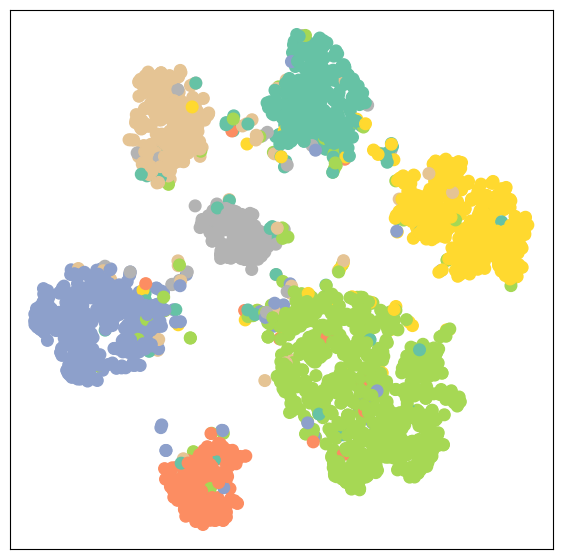

In [ ]:
model1.eval()

out = model1(graph)
visualize(out, color=graph.y)

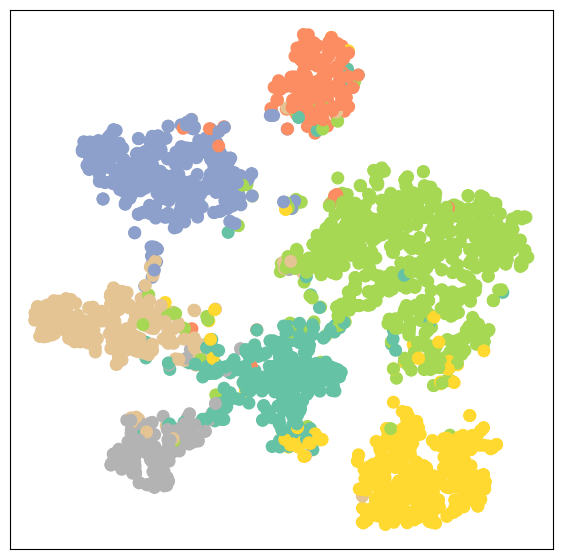

In [ ]:
model2.eval()

out = model2(graph)
visualize(out, color=graph.y)

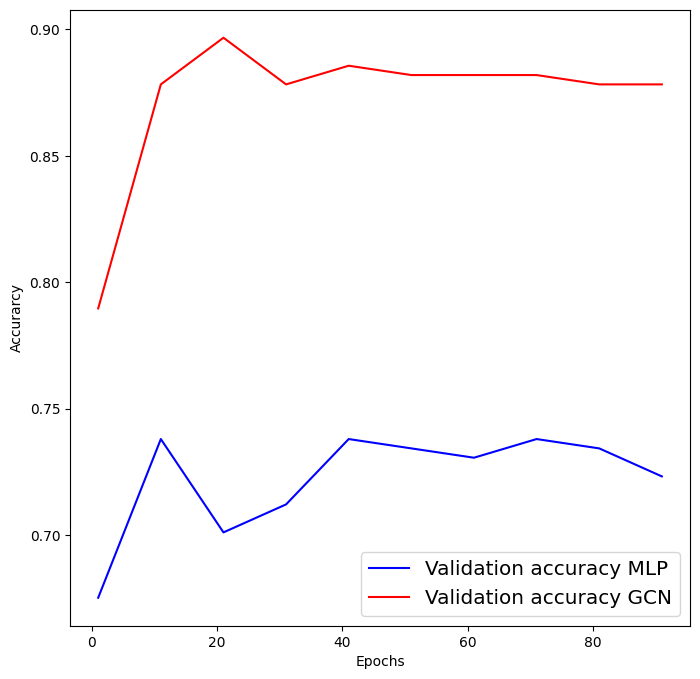

In [ ]:
import numpy as np

plt.figure(figsize=(8,8))
plt.plot(np.arange(1, (len(val_acc_mlp))*10,10), val_acc_mlp, label='Validation accuracy MLP', c='blue')
plt.plot(np.arange(1, (len(val_acc_gcn))*10,10), val_acc_gcn, label='Validation accuracy GCN', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

In [ ]:
from torch_geometric.nn import GATConv

data = graph

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0197, Val: 0.5498, Test: 0.4945
Epoch: 002, Loss: 3.7274, Val: 0.5092, Test: 0.5000
Epoch: 003, Loss: 3.4203, Val: 0.5129, Test: 0.4742
Epoch: 004, Loss: 3.1040, Val: 0.5018, Test: 0.4668
Epoch: 005, Loss: 2.7465, Val: 0.5018, Test: 0.4686
Epoch: 006, Loss: 2.3985, Val: 0.4945, Test: 0.4705
Epoch: 007, Loss: 2.1348, Val: 0.5055, Test: 0.4945
Epoch: 008, Loss: 1.8514, Val: 0.5314, Test: 0.5092
Epoch: 009, Loss: 1.6571, Val: 0.5461, Test: 0.5221
Epoch: 010, Loss: 1.5028, Val: 0.6052, Test: 0.5701
Epoch: 011, Loss: 1.4376, Val: 0.6753, Test: 0.6365
Epoch: 012, Loss: 1.2827, Val: 0.7196, Test: 0.7030
Epoch: 013, Loss: 1.1934, Val: 0.8007, Test: 0.7786
Epoch: 014, Loss: 1.1175, Val: 0.8339, Test: 0.8063
Epoch: 015, Loss: 1.0615, Val: 0.8450, Test: 0.8284
Epoch: 016, Loss: 0.9468, Val: 0.8561, Test: 0.8395
Epoch: 017, Loss: 0.9351, Val: 0.8672, Test: 0.8450
Epoch: 018, Loss: 0.8713, Val: 0.8782

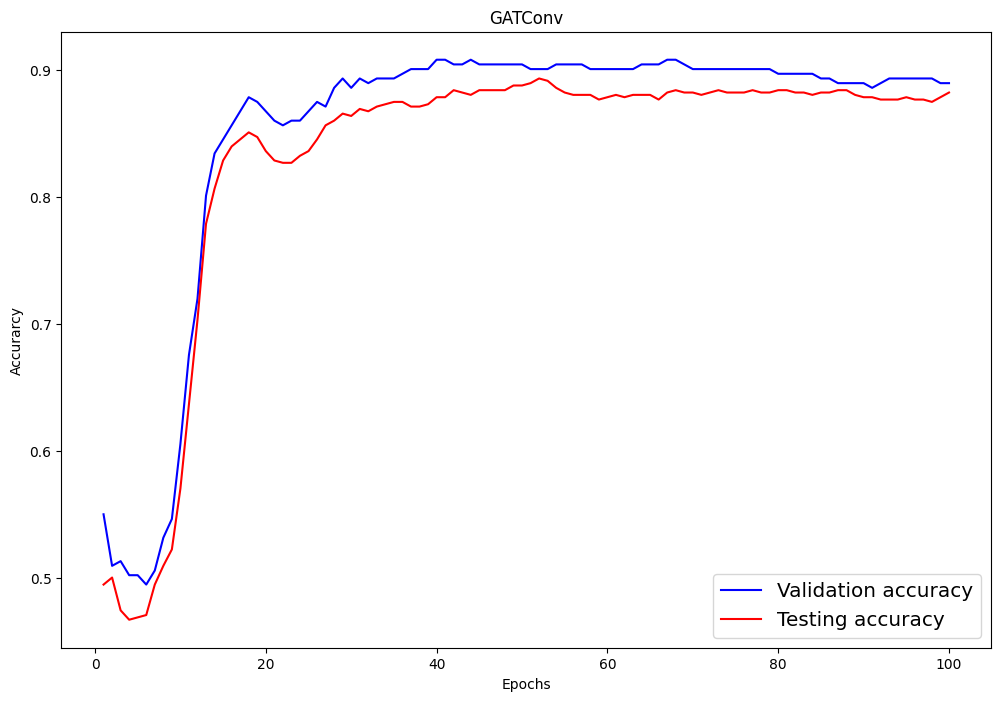

In [ ]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

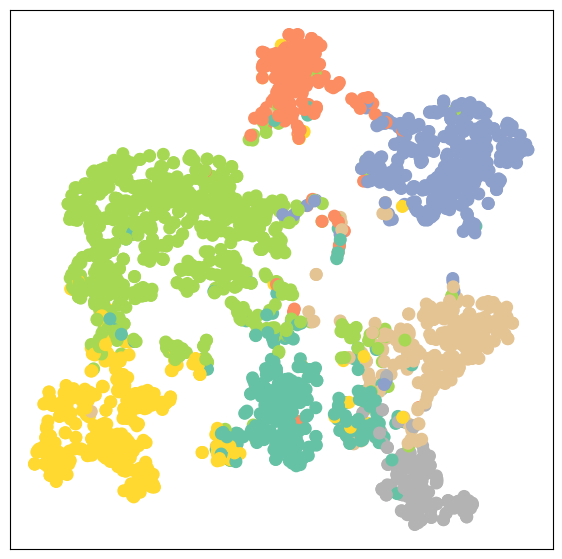

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Link prediction on citation dataset

In [ ]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [ ]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [ ]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [ ]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))



In epoch 0, loss: 0.7317293882369995
In epoch 5, loss: 0.6925657391548157
In epoch 10, loss: 0.6907758116722107
In epoch 15, loss: 0.6787835359573364
In epoch 20, loss: 0.6427046060562134
In epoch 25, loss: 0.5807392597198486
In epoch 30, loss: 0.5440965294837952
In epoch 35, loss: 0.5205307602882385
In epoch 40, loss: 0.5072329640388489
In epoch 45, loss: 0.48863133788108826
In epoch 50, loss: 0.47105199098587036
In epoch 55, loss: 0.45532143115997314
In epoch 60, loss: 0.4403887689113617
In epoch 65, loss: 0.4282307028770447
In epoch 70, loss: 0.41460657119750977
In epoch 75, loss: 0.4020746350288391
In epoch 80, loss: 0.38971763849258423
In epoch 85, loss: 0.37749773263931274
In epoch 90, loss: 0.3656172454357147
In epoch 95, loss: 0.35395383834838867
AUC 0.8514867141349027
